This is the reproduction of data from NA49 experiment with fixed target and the beam momentum equal 158 GeV

In [229]:
mp = 0.93827                                                           #proton mass
pz = 158.0                                                             #beam momentum
root_s = (2 * mp * (mp + (mp ** 2 +pz ** 2) ** 0.5)) ** 0.5            #sqrt(s)
norm = 3.141593 * root_s / 2                                           #normalization in new coordinats
sig_trig = 28.23                                                       #trigger cross section

> ## Generating

In [203]:
import sys

cfg = open('/Users/artyom/Software/pythia/pythia8307/Makefile.inc')
lib = '../lib'

for line in cfg:

    if line.startswith('PREFIX_LIB='): lib = line[11:-1]; break
    
sys.path.insert(0, lib)

import pythia8

In [204]:
N_events = int(1e7) 
ids = [-211, 211, -321, 321]

In [205]:
pythia = pythia8.Pythia('printBanner = false')

files = dict(zip(ids, [open(f'data/generated/{id}.csv', 'w') for id in ids]))

for id in ids: files[id].write('pT,xF,E\n')

pythia.readFile('config/config.cmnd')

boost = pythia8.Vec4()
boost.pz(mp * ((1 + (pz / mp) ** 2) ** 0.5 - 1) ** 0.5)
boost.e((boost.pz() ** 2 + mp ** 2) ** 0.5)

pythia.init()

for event in range(N_events):

    if not pythia.next(): continue
    
    entries = pythia.event.size()

    for j in range(entries):

        particle = pythia.event[j]

        id = particle.id()
        
        if abs(int(id)) == 211 or abs(int(id)) == 321:

            P_mu = particle.p()

            P_mu.bstback(boost)

            pT = P_mu.pT()
            xF = 2 * P_mu.pz() / root_s
            E = P_mu.e()

            files[id].write(f'{pT},{xF},{E}\n')

sig_total = pythia.getSigmaTotal()

pythia.stat()

for id in ids: files[id].close()


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.307      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 25 Feb 2022  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 02 Nov 2022 at 19:36:59    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

In [206]:
print(boost)

     0.000     0.000    12.140    12.176 (    0.938)



In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

> ## Binning

In [208]:
bins_file = open('config/binning.bin', 'r')

In [209]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

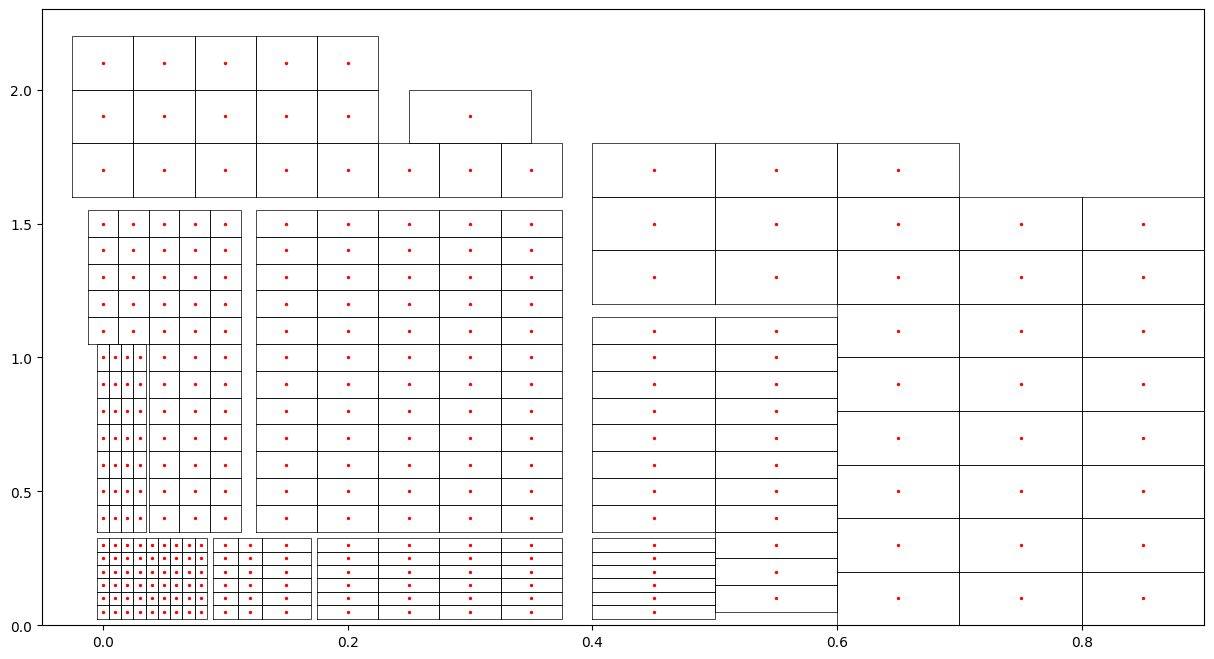

In [210]:
from matplotlib import patches

plt.figure(figsize=(15, 8))

for bin in bins:

    x = bin[0] - bin[2]
    y = bin[1] - bin[3]
    w = 2 * bin[2]
    h = 2 * bin[3]

    plt.plot([x, x, x + w, x + w, x], [y, y + h, y + h, y, y], color='black', lw=0.5)
    plt.scatter(x + w / 2, y + h / 2, color='red', s=2)

plt.xlim(-0.05, 0.9)
plt.ylim(0, 2.3)

plt.show()

In [288]:
def xsect_calc(data):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * (data['xF'] < xF + dxF / 2) * (data['pT'] > pT - dpT / 2) * (data['pT'] < pT + dpT / 2)

        dn = data[mask_for_bin]['E'].size

        dp3 = dxF * 2 * pT * dpT

        E = data[mask_for_bin]['E']

        xsect.append((E * (sig_total / N_events) * (dn / dp3) / norm).mean())
        err.append((E * (sig_total / N_events) * (dn / dp3) / norm).std())

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, err)

    return xsect, err

In [367]:
def plot_compare(xsect, err, ref):

    n = ref['xF'].unique().size

    plt.figure(figsize=(20, 7 * n))

    for num, xF in enumerate(ref['xF'].unique()):

        pT_axis = np.intersect1d(bins[:, 1][bins[:, 0] == xF][::-1], ref['pT'][ref['xF'] == xF])

        plt.subplot(n, 3, num * 3 + 1)
        plt.errorbar(pT_axis, xsect[(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1],
                     yerr=err[(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1], label='gen')
        plt.errorbar(pT_axis, ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)], 
                    yerr=ref['error'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)],
                    label='exp')
        plt.legend()
        plt.title(f'$xF={xF}$')

        plt.subplot(n, 3, num * 3 + 2)
        plt.errorbar(pT_axis, xsect[(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1],
                     yerr=err[(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1], label='gen')
        plt.errorbar(pT_axis, ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)], 
                    yerr=ref['error'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)],
                    label='exp')
        plt.yscale('log')
        plt.legend()
        plt.title(f'$xF={xF}$ log scale')

        delta = ((xsect[(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] - ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)]) /
                 ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)])
        delta_err = delta * ((err / np.where(xsect == 0, 1, xsect))[(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] +
                             (ref['error'] / ref['xsect'])[(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)])

        plt.subplot(n, 3, num * 3 + 3)
        plt.errorbar(pT_axis, delta, yerr=delta_err)
        plt.plot(pT_axis, np.zeros_like(pT_axis), '--', color='red')
        plt.title(f'$xF={xF}$ relative deviation')
        
    plt.show()

> ## $\pi^{+}$ differential cross sectciont comparesment

In [368]:
id = 211

In [369]:
data = pd.read_csv(f'data/generated/{id}.csv')
ref = pd.read_csv(f'data/experimental/{id}.csv')

In [370]:
xsect, err = xsect_calc(data)

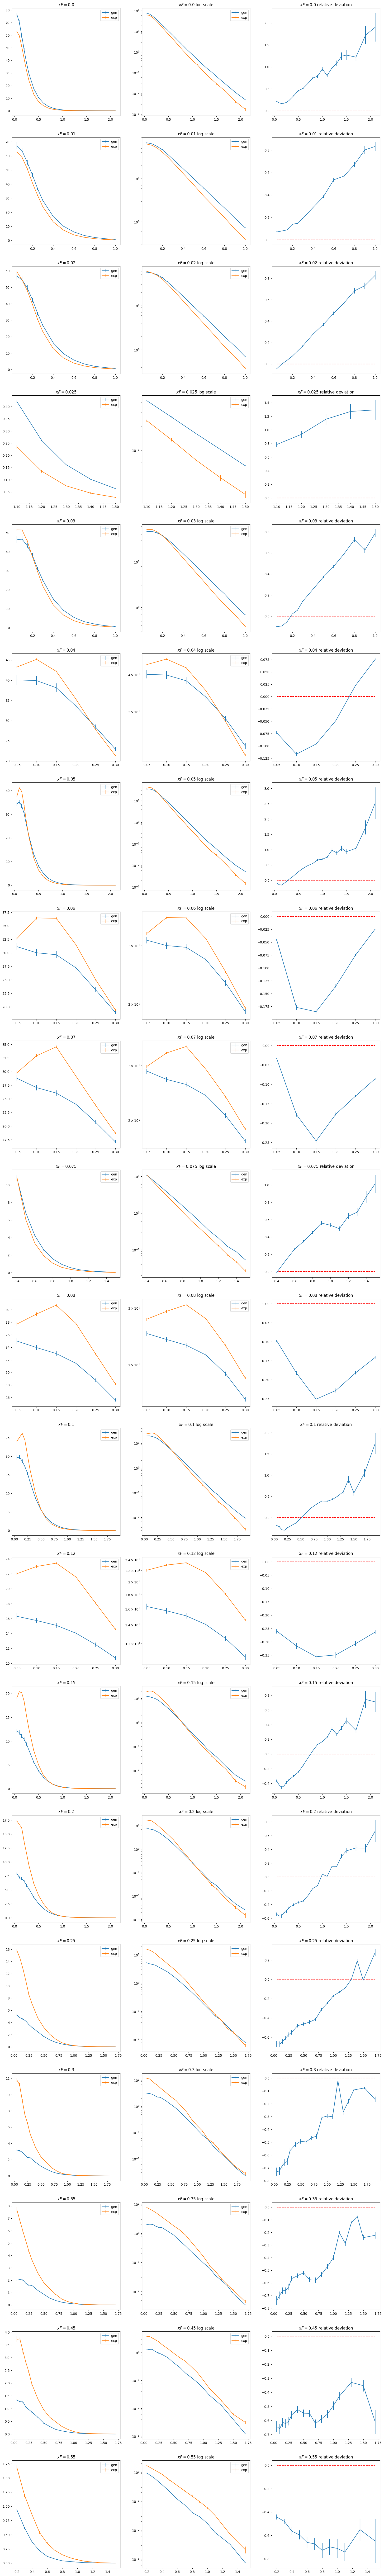

In [371]:
plot_compare(xsect, err, ref)

> ## $\pi^{-}$ differential cross sectciont comparesment

In [372]:
id = -211

In [373]:
data = pd.read_csv(f'data/generated/{id}.csv')
ref = pd.read_csv(f'data/experimental/{id}.csv')

In [374]:
xsect, err = xsect_calc(data)

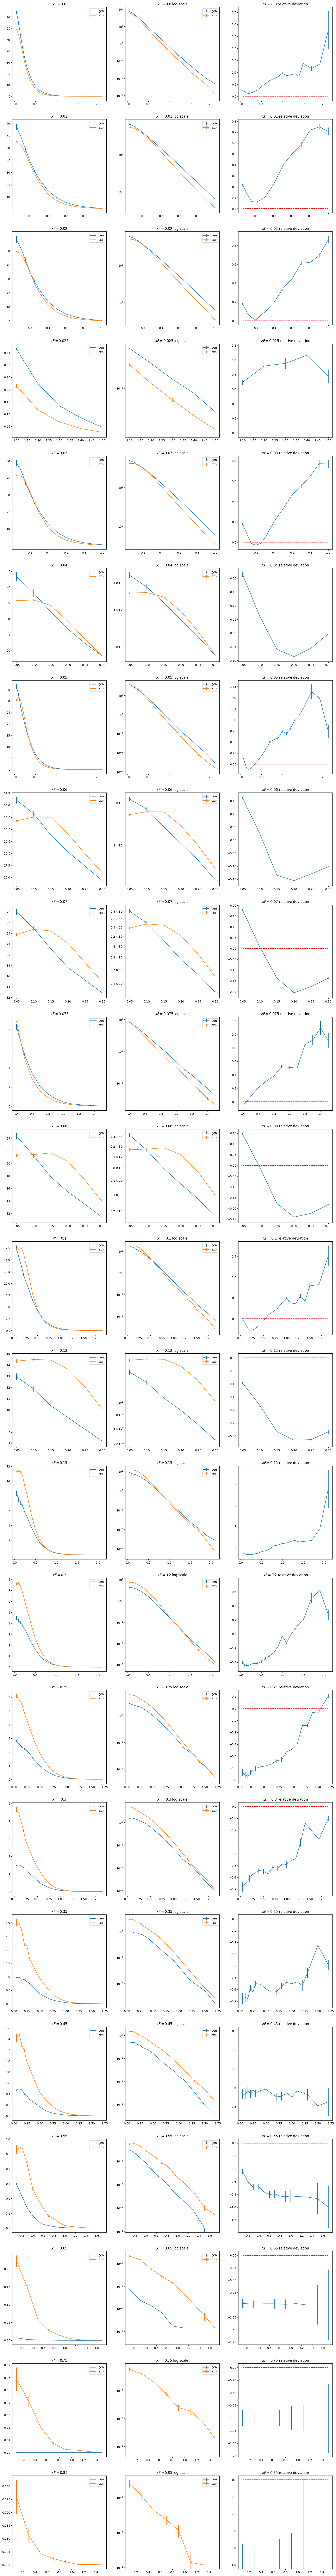

In [375]:
plot_compare(xsect, err, ref)

> ## $K^{+}$ differential cross sectciont comparesment

In [376]:
id = 321

In [377]:
data = pd.read_csv(f'data/generated/{id}.csv')
ref = pd.read_csv(f'data/experimental/{id}.csv')

In [378]:
xsect, err = xsect_calc(data)

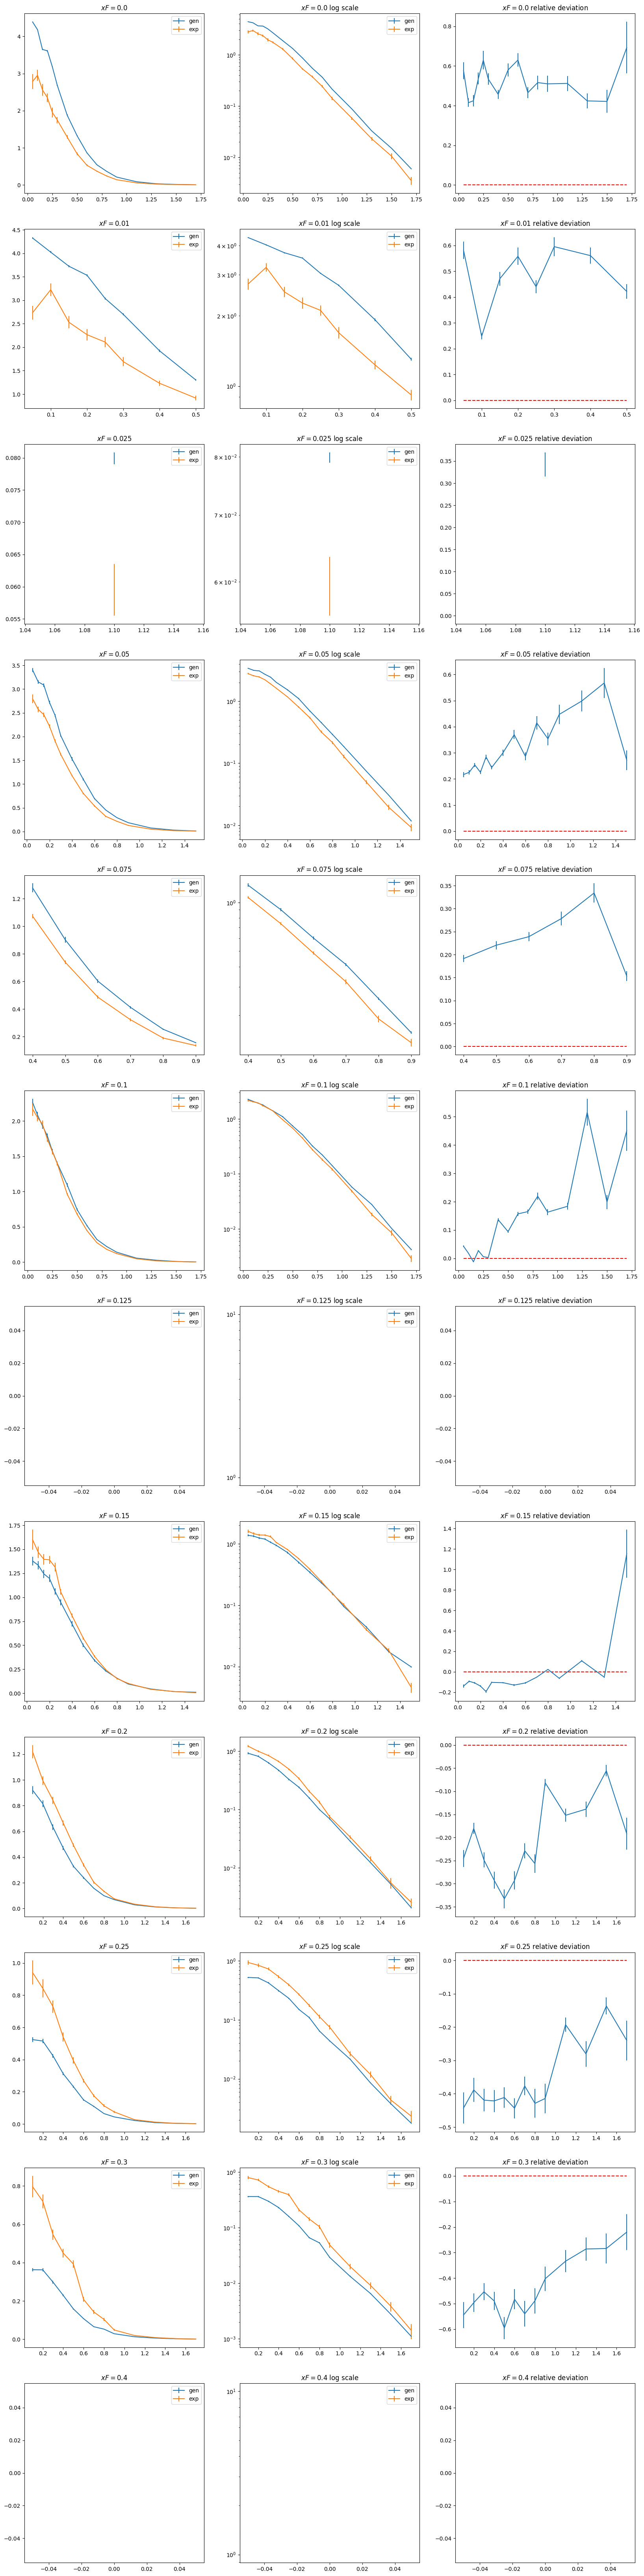

In [379]:
plot_compare(xsect, err, ref)

> ## $K^{-}$ differential cross sectciont comparesment

In [380]:
id = -321

In [381]:
data = pd.read_csv(f'data/generated/{id}.csv')
ref = pd.read_csv(f'data/experimental/{id}.csv')

In [382]:
xsect, err = xsect_calc(data)

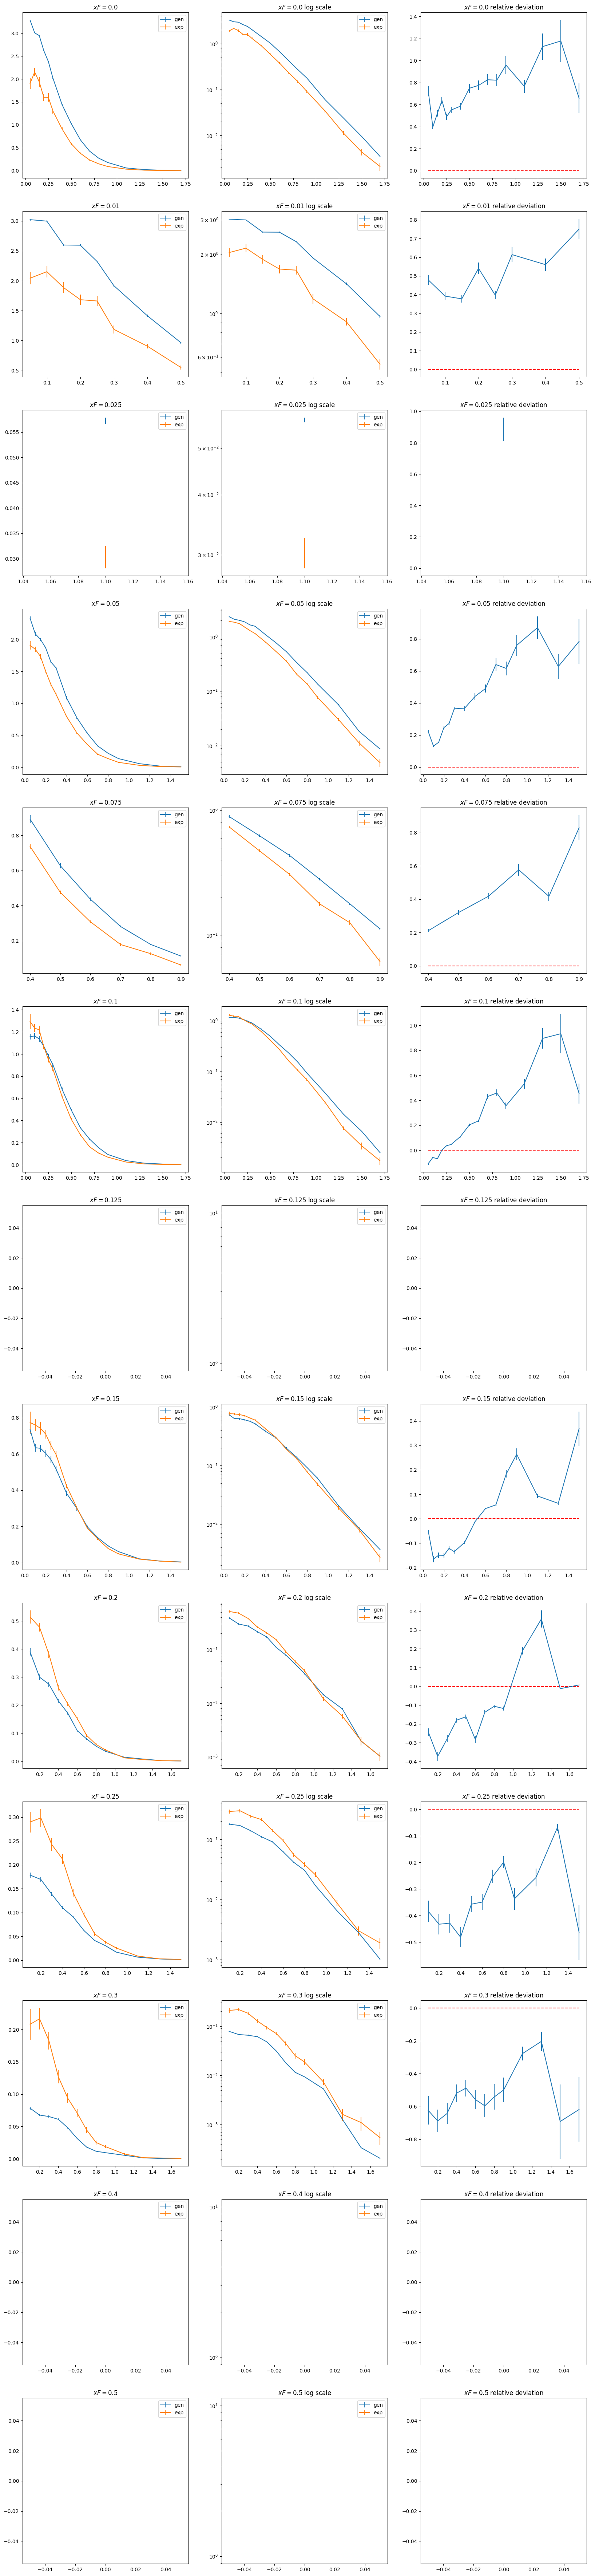

In [383]:
plot_compare(xsect, err, ref)